- 自然语言处理（NLP）简介
- 预处理文本输入，将其转换为数值输入
- 构建简单的文本分类模型，为更复杂的Transformer模型做好准备

## 准备文本数据

文本数据的障碍：输入并非数值型数据，需要将文字转换为数字张量，文本的数值可以通过多种方式构建：

1. 将输入内容分割成一系列字符，并为每个字符分配一个唯一的索引
2. 构建基于单词的表示：首先将句子按空格和标点符号拆分，然后将每个单词映射到唯一的数字表示

两种都有用，所有文本预处理都会包含一个分割步骤，即将文本分割成称为"词元"的小单元。

### 字母和词的分词

In [2]:
import regex as re

def split_chars(text):
    return re.findall(r".", text)

In [3]:
chars = split_chars("The quick brown fox jumps over the lazy dog")
chars[:12]

['T', 'h', 'e', ' ', 'q', 'u', 'i', 'c', 'k', ' ', 'b', 'r']

In [4]:
# [\w]+" 正则表达式会匹配连续的非空白字符，并且 "[.,!?;]"能够匹配括号内的标点符号。可以将两者结合起来，得到一个能够将每个单词和标点符号拆分成一个标记的正则表达式：

def split_words(text):
    return re.findall(r"[\w]+|[.,!?;]", text)

In [5]:
split_words("The quick brown fox jumped over the dog.")

['The', 'quick', 'brown', 'fox', 'jumped', 'over', 'the', 'dog', '.']

分词（splitting）将从一个完整的字符串转换为一个**词元序列（token sequence）**，但仍然需要把这些字符串词元转换成**数值输入（numeric inputs）**。
目前最常见的方法是为每个词元分配一个**唯一的整数索引（integer index）**，这种过程通常称为**输入索引化（indexing our input）**。

这种表示方法具有灵活且可逆的特性，能广泛应用于各种建模方式。
之后，可以再决定如何将这些**词元索引（token indices）** 映射到模型可接收的 **潜在空间（latent space）** 中。

对于字符级token，可以使用ASCII查询来建立索引——例如，ord('A')→65、ord('z')→122。但这种方法在涉及非英文时扩展性较差——Unicode标准包含超过一百万个字符！更稳健的技术是基于训练数据中的特定token构建索引映射，这种在自然语言处理中称为"词汇表"的技术，其优势在于能同等适用于单词级和字符级token的处理。

In [7]:
vocabulary = {
    "[UNK]": 0,
    "the": 1,
    "quick": 2,
    "brown": 3,
    "fox": 4,
    "jumped": 5,
    "over": 6,
    "dog": 7,
    ".": 8,
}
words = split_words("The quick brown fox jumped over the lazy dog.")
indices = [vocabulary.get(word, 0) for word in words]

indices

[0, 2, 3, 4, 5, 6, 1, 0, 7, 8]

UNK： 代表一个词汇表未知的token，处理所有输入，即使这个token只出现了测试集

很多句子非常相似（几乎一样），只有字母大小写，有没有引号，缩写区别或者简体繁体的区别，但是模型并不知道他们没有什么区别，所以需要对文本做标准化避免几乎相同的句子编码差异。不要让模型去处理相同句子的不同表示

标准化操作：转小写，去标点符号，繁体转简体

文本预处理的三个阶段：
1. **Standardization（标准化）** —— 对输入文本进行基本的文本到文本的规范化转换。
2. **Splitting（分词）** —— 将文本切分为由词元（token）组成的序列。
3. **Indexing（索引化）** —— 使用词汇表（vocabulary）将词元映射为索引。


文本 -> 标准化文本 -> 词元 -> 词元索引

人们通常把整个过程称为 tokenization（词元化），而把“将文本映射为词元索引序列的对象”称为 tokenizer（分词器）。

![文本预处理](./images/text_preprocess.png)

In [8]:
# character-level 分词器
class CharTokenizer:
    def __init__(self, vocabulary):
        self.vocabulary = vocabulary
        self.unk_id = vocabulary["[UNK]"]

    def standardize(self, inputs):
        return inputs.lower()

    def split(self, inputs):
        return re.findall(r".", inputs)

    def index(self, tokens):
        return [self.vocabulary.get(t, self.unk_id) for t in tokens]

    def __call__(self, inputs):
        inputs = self.standardize(inputs)
        tokens = self.split(inputs)
        indices = self.index(tokens)
        return indices


在使用这一方法之前，还需要编写一个函数，用于根据输入文本**构建词元（token）词表**。

与其简单地把所有字符都映射到唯一的索引上，更希望能**限制词表的大小**，只保留输入数据中**最常见的词元**。

当进入模型构建阶段时，**限制词表大小**将成为**控制模型参数数量**的重要手段。


In [9]:
import collections

def compute_char_vocabulary(inputs, max_size):
    char_counts = collections.Counter()
    for x in inputs:
        x = x.lower()
        tokens = re.findall(r".", x)
        char_counts.update(tokens)

    vocabulary = ["[UNK]"]
    most_common = char_counts.most_common(max_size - len(vocabulary))
    for token, count in most_common:
        vocabulary.append(token)
    return dict((token, i) for i, token in enumerate(vocabulary))

In [10]:
# 建立一个 word-level 分词器（tokenizer) , 只需要改分割的规则
class WordTokenizer:
    def __init__(self, vocabulary):
        self.vocabulary = vocabulary
        self.unk_id = vocabulary["[UNK]"]

    def standardize(self, inputs):
        return inputs.lower()

    def split(self, inputs):
        return re.findall(r"[\w]+|[.,!?;]", inputs)

    def index(self, tokens):
        return [self.vocabulary.get(t, self.unk_id) for t in tokens]

    def __call__(self, inputs):
        inputs = self.standardize(inputs)
        tokens = self.split(inputs)
        indices = self.index(tokens)
        return indices


In [11]:
# 换一个新的分割规则，变成计算word-level的词汇表
def compute_word_vocabulary(inputs, max_size):
    word_counts = collections.Counter()
    for x in inputs:
        x = x.lower()
        tokens = re.findall(r"[\w]+|[.,!?;]", x)
        word_counts.update(tokens)

    vocabulary = ["[UNK]"]
    most_common = word_counts.most_common(max_size - len(vocabulary))
    for token, count in most_common:
        vocabulary.append(token)
    return dict((token, i) for i, token in enumerate(vocabulary))


![keras和它的后端](./images/RNN/keras.png)

In [17]:
import keras
from keras.datasets import mnist

(train_images, train_labels), (test_images, test_labels) = mnist.load_data()

In [18]:
model = keras.Sequential([
    keras.Input(shape=(28, 28, 1)),
    keras.layers.Conv2D(filters=64, kernel_size=3, activation="relu"),
    keras.layers.MaxPooling2D(pool_size=2),
    keras.layers.Conv2D(filters=128, kernel_size=3, activation="relu"),
    keras.layers.MaxPooling2D(pool_size=2),
    keras.layers.Conv2D(filters=256, kernel_size=3, activation="relu"),
    keras.layers.GlobalAveragePooling2D(),
    keras.layers.Dense(units=10)
])

In [19]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 26, 26, 64)     │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 13, 13, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 11, 11, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 5, 5, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 3, 3, 256)      │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 256)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 10)             │         2,570 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 372,234 (1.42 MB)

 Trainable params: 372,234 (1.42 MB)

 Non-trainable params: 0 (0.00 B)

In [20]:
train_images = train_images.reshape((60000, 28, 28, 1))
train_images = train_images.astype("float32") / 255
test_images = test_images.reshape((10000, 28, 28, 1))
test_images = test_images.astype("float32") / 255

In [21]:
model.compile(optimizer="adam", loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=["accuracy"])
model.fit(train_images, train_labels, epochs=5, batch_size=64)

Epoch 1/5
938/938 ━━━━━━━━━━━━━━━━━━━━ 9s 9ms/step - accuracy: 0.9236 - loss: 0.2498
Epoch 2/5
938/938 ━━━━━━━━━━━━━━━━━━━━ 8s 9ms/step - accuracy: 0.9779 - loss: 0.0705
Epoch 3/5
938/938 ━━━━━━━━━━━━━━━━━━━━ 8s 9ms/step - accuracy: 0.9845 - loss: 0.0494
Epoch 4/5
938/938 ━━━━━━━━━━━━━━━━━━━━ 9s 9ms/step - accuracy: 0.9880 - loss: 0.0375
Epoch 5/5
938/938 ━━━━━━━━━━━━━━━━━━━━ 8s 9ms/step - accuracy: 0.9913 - loss: 0.0286


In [22]:
model.evaluate(test_images, test_labels)

313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.9918 - loss: 0.0272


[0.027248626574873924, 0.9918000102043152]

In [15]:
# 自定义分词器 用于现实中的文本输入


filename = keras.utils.get_file(
    origin="https://www.gutenberg.org/files/2701/old/moby10b.txt",
)
moby_dick = list(open(filename, "r"))

vocabulary = compute_char_vocabulary(moby_dick, max_size=100)
char_tokenizer = CharTokenizer(vocabulary)


1256167/1256167 ━━━━━━━━━━━━━━━━━━━━ 2s 1us/step


In [13]:
print("Vocabulary length: ", )

In [23]:
print("Vocabulary length:", len(vocabulary))
print("Vocabulary start:", list(vocabulary.keys())[:10])
print("Vocabulary end:", list(vocabulary.keys())[-10:])
print("Line length:", len(char_tokenizer( "Call me Ishmael. Some years ago--never mind how long precisely.")))

Vocabulary length: 64
Vocabulary start: ['[UNK]', ' ', 'e', 't', 'a', 'o', 'n', 'i', 's', 'h']
Vocabulary end: ['@', '$', '%', '#', '=', '~', '&', '+', '<', '>']
Line length: 63


In [24]:
vocabulary = compute_word_vocabulary(moby_dick, max_size=2_000)
word_tokenizer = WordTokenizer(vocabulary)

In [25]:
print("Vocabulary length:", len(vocabulary))
print("Vocabulary start:", list(vocabulary.keys())[:5])
print("Vocabulary end:", list(vocabulary.keys())[-5:])
print("Line length:", len(word_tokenizer("Call me Ishmael. Some years ago--never mind how long precisely.")))

Vocabulary length: 2000
Vocabulary start: ['[UNK]', ',', 'the', '.', 'of']
Vocabulary end: ['tambourine', 'subtle', 'perseus', 'elevated', 'repose']
Line length: 13


已经可以看到两种分词（tokenization）方法的优缺点。
字符级分词器（character-level tokenizer） 只需要 64 个词汇项就能覆盖整本书，但会把每个输入编码成非常长的序列。
词级分词器（word-level tokenizer） 很快就能填满一个包含 2000 个词的词表（如果想覆盖整本书中出现的所有词汇，你需要一个包含 17,000 个词的词典！），但词级分词器输出的序列会短得多。

随着机器学习实践者使用越来越多的数据和参数来扩大模型规模，词级分词和字符级分词各自的缺陷也逐渐显现。
词级分词带来的“压缩”效果实际上非常重要——它能让模型一次读取更长的文本序列。
但是，如果你尝试为一个大型数据集（如今的数据集可能包含数万亿个单词）构建词级词表，那么这个词表将会大到难以处理，可能包含上亿个词条。
而如果你为了限制词表大小而强行压缩它，那么会导致大量文本被编码成 "[UNK]"（未知词符），从而丢失宝贵的信息。

这些问题促使一种新的分词方式流行起来——子词分词（subword tokenization），
它试图在词级和字符级分词之间找到一个平衡点。

### 子词分词

子词分词（Subword tokenization） 的目标是结合 字符级编码 和 词级编码 的优点。
希望既能拥有 词级分词器（WordTokenizer） 那种输出简洁的特性，
又能具备 字符级分词器（CharTokenizer） 那种用极小词表就能编码各种输入的能力。

可以把寻找理想分词器的过程，看作是在寻找一种理想的数据压缩方式。
减少词元（token）的数量，相当于压缩输入序列的总体长度；
而使用更小的词表，则能减少表示每个词元所需的存储字节数。
如果能同时做到这两点，就可以把短且信息密度高的序列输入到深度学习模型中。

压缩与分词之间的这种类比并非一开始就显而易见，但事实证明它非常有用。
在过去十年的自然语言处理研究中，最实用、最有效的技巧之一
是重新利用 1990 年代的一种无损压缩算法——字节对编码（Byte-Pair Encoding, BPE） 来做分词。
这一算法至今仍被 ChatGPT 以及许多其他模型所采用。

字节对编码（BPE）的核心思想是：
从最基础的字符级词表开始，
逐步地将出现频率最高的字符对（pair）合并，形成越来越长的子词序列。（找出在语料中相邻出现最频繁的符号对（pair），逐步合并成更大的子词。）

将实现一个使用 BPE 算法 的分词器。

In [26]:
data = [
    "the quick brown fox",
    "the slow brown fox",
    "the quick brown foxhound",
]  # 假设这是一个数据集

与 WordTokenizer（词级分词器） 类似，首先要统计文本中所有单词的出现次数。
在创建单词计数字典的过程中，会把所有文本拆分成单个字符，
然后用空格将这些字符连接起来。

这样处理的目的是：
在接下来的步骤中，就能更方便地统计并合并字符对（character pairs）。

In [27]:
def count_and_split_words(data):
    counts = collections.Counter()
    for line in data:
        line = line.lower()
        for word in re.findall(r"[\w]+|[.,!?;]", line):
            chars = re.findall(r".", word)
            split_word = " ".join(chars)
            counts[split_word] += 1
    return dict(counts)

counts = count_and_split_words(data)

In [28]:
counts

{'t h e': 3,
 'q u i c k': 2,
 'b r o w n': 3,
 'f o x': 2,
 's l o w': 1,
 'f o x h o u n d': 1}

为了在拆分后的词频统计上应用 字节对编码（Byte-Pair Encoding, BPE），
需要找到一对字符并将它们合并成一个新的符号。

具体来说，会在所有单词中遍历所有可能的字符对（character pairs），
然后只合并其中出现频率最高的一对。

在前面的例子中，最常见的字符对是 ("o", "w")，
它出现在单词 “brown”（在数据中出现了三次）和 “slow”（出现一次）中。
因此将这对字符合并为一个新的符号 “ow”，
并把所有出现的 “o w” 替换成 “ow”。

接着继续重复这个过程：
统计新的字符对频率、找到最常见的一对并进行合并。
不同的是，现在 “ow” 被视为一个整体符号，
它可能会再与 “l” 合并形成 “low”。

通过这种不断合并出现频率最高的符号对的方式，
逐步构建出一个越来越大的子词词表（subword vocabulary）。

In [29]:
def count_pairs(counts):
    pairs = collections.Counter()
    for word, freq in counts.items():
        symbols = word.split()
        for pair in zip(symbols[:-1], symbols[1:]):
            pairs[pair] += freq

    return pairs

def merge_pair(counts, first, second):
    #  在“空格分隔的词元序列”中，前后都不是字母/数字的地方，找出 完整独立的“{first} {second}” 组合。
    split = re.compile(f"(?<!\S){first} {second}(?!\S)")

    # 把所有的组合 换成 合并的
    merged = f"{first}{second}"
    return {split.sub(merged, word): count for word, count in counts.items()}

for i in range(10):
    pairs = count_pairs(counts)
    first, second = max(pairs, key=pairs.get)
    counts = merge_pair(counts, first, second)
    print(list(counts.keys()))

['t h e', 'q u i c k', 'b r ow n', 'f o x', 's l ow', 'f o x h o u n d']
['th e', 'q u i c k', 'b r ow n', 'f o x', 's l ow', 'f o x h o u n d']
['the', 'q u i c k', 'b r ow n', 'f o x', 's l ow', 'f o x h o u n d']
['the', 'q u i c k', 'br ow n', 'f o x', 's l ow', 'f o x h o u n d']
['the', 'q u i c k', 'brow n', 'f o x', 's l ow', 'f o x h o u n d']
['the', 'q u i c k', 'brown', 'f o x', 's l ow', 'f o x h o u n d']
['the', 'q u i c k', 'brown', 'fo x', 's l ow', 'fo x h o u n d']
['the', 'q u i c k', 'brown', 'fox', 's l ow', 'fox h o u n d']
['the', 'qu i c k', 'brown', 'fox', 's l ow', 'fox h o u n d']
['the', 'qui c k', 'brown', 'fox', 's l ow', 'fox h o u n d']


可以看到，高频词通常会被完全合并成一个整体，而低频词则只会被部分合并。

接下来，可以把这一过程扩展为一个完整的函数，用于构建 字节对编码（Byte-Pair Encoding, BPE）词表。

首先以输入文本中出现的所有字符作为初始词表，
然后不断地将出现频率最高的符号对（pair）合并，
逐步向词表中加入越来越长的子词（subword），
直到词表的大小达到设定的目标。

同时，还需要维护一个单独的合并规则字典（merge rules），
记录每次合并的符号对及其合并顺序（rank order）。

在下一步中，将利用这些合并规则来对新的输入文本进行分词。

In [31]:
def compute_sub_word_vocabulary(dataset, vocab_size):
    counts = count_and_split_words(dataset)

    char_counts = collections.Counter()
    for word in counts:
        for char in word.split():
            char_counts[char] += counts[word]

    most_common = char_counts.most_common()
    vocab = ["[UNK]"] + [char for char, freq in most_common]
    merges = []

    while len(vocab) < vocab_size:
        pairs = count_pairs(counts)
        if not pairs:
            break
        first, second = max(pairs, key=pairs.get)
        counts = merge_pair(counts, first, second)
        vocab.append(f"{first}{second}")
        merges.append(f"{first} {second}")

    vocab = dict((token, index) for index, token in enumerate(vocab))
    merges = dict((token, rank) for rank, token in enumerate(merges))

    return vocab, merges

让来构建一个 SubWordTokenizer（子词分词器），它能够根据学到的 **合并规则（merge rules)** 来对新的输入文本进行分词。

其中，standardize() 和 index() 两个步骤可以与 WordTokenizer（词级分词器） 保持一致，所有的变化都将发生在 split() 方法 中。

在分词步骤中，首先将输入文本按空格切分成单词，然后再将每个单词拆分成字符，接着应用训练得到的合并规则，逐步将相邻字符合并。

经过这些合并后，剩下的就是子词（subwords） ——这些子词可能是完整的单词、单词的一部分，也可能只是单个字符，具体取决于该单词在训练数据中的出现频率。

最终，这些子词（subwords）就构成了的输出词元（tokens）。

In [32]:
class SubWordTokenizer:
    def __init__(self, vocabulary, merges):
        self.vocabulary = vocabulary
        self.merges = merges
        self.unk_id = vocabulary["[UNK]"]

    def standardize(self, inputs):
        return inputs.lower()

    def bpe_merge(self, word):
        while True:
            # 匹配word里所有的符号对
            pairs = re.findall(r"(?<!\S)\S+ \S+(?!\S)", word, overlapped=True)
            if not pairs:
                break

            # 通过rank 执行merge规则，最频繁的 符号对最先合并
            best = min(pairs, key=lambda pair: self.merges.get(pair, 1e9))
            if best not in self.merges:
                break

            first, second = best.split()
            split = re.compile(f"(?<!\S){first} {second}(?!\S)")
            merged = f"{first}{second}"
            word = split.sub(merged, word)
        return word


    def split(self, inputs):
        tokens = []
        # 切分单词
        for word in re.findall(r"[\w]+|[.,!?;]", inputs):
            # 通过空格连接字母
            word = " ".join(re.findall(r".", word))

            # 应用BPE编码规则
            word = self.bpe_merge(word)
            tokens.extend(word.split())
        return tokens

    def index(self, tokens):
        return [self.vocabulary.get(t, self.unk_id) for t in tokens]

    def __call__(self, inputs):
        inputs = self.standardize(inputs)
        tokens = self.split(inputs)
        indices = self.index(tokens)
        return indices

In [33]:
vocabulary, merges = compute_sub_word_vocabulary(moby_dick, 2_000)
sub_word_tokenizer = SubWordTokenizer(vocabulary, merges)

In [34]:
print("Vocabulary length:", len(vocabulary))
print("Vocabulary start:", list(vocabulary.keys())[:10])
print("Vocabulary end:", list(vocabulary.keys())[-7:])
print("Line length:", len(sub_word_tokenizer("Call me Ishmael. Some years ago--never mind how long precisely."
)))

Vocabulary length: 2000
Vocabulary start: ['[UNK]', 'e', 't', 'a', 'o', 'n', 'i', 's', 'h', 'r']
Vocabulary end: ['bright', 'pilot', 'sco', 'ben', 'dem', 'gale', 'ilo']
Line length: 16


对于的测试句子来说，SubWordTokenizer（子词分词器） 的分词结果稍微比 WordTokenizer（词级分词器） 长一些（16 个词元 vs 13 个词元），
但与 WordTokenizer 不同的是，SubWordTokenizer 能够对《白鲸记》（Moby Dick）中的每一个单词进行分词，而无需使用 "[UNK]"（未知词）标记。SubWordTokenizer 不需要 [UNK]，因为它的词表覆盖了所有字符（字符级基础），任何新词都能被拆分成已知的子词或字符组合。

因为词表中包含了源文本中的所有字符，所以在最糟糕的情况下，模型也只是把一个单词拆成单个字符来处理。换句话说，在保持较短平均词元长度的同时，又能用一个较小的词表有效地处理罕见词。 这正是 **子词分词器（subword tokenizer**的优势所在。

你可能会注意到，运行这段代码的速度要明显慢于字符级或词级分词器——大约需要一分钟左右。这是因为学习合并规则（merge rules）的过程远比简单地统计输入数据集中的单词频率复杂得多。虽然这是子词分词的一项缺点，但在实际应用中，这通常并不是什么严重问题：一个模型只需要学习一次词表，
而子词词表学习的开销，相比于模型训练成本，几乎可以忽略不计。

已经看到了三种不同的文本分词方法。现在，已经能够把文本转换为数值输入，接下来就可以进入模型训练阶段了。

虽然理解分词器的工作原理非常重要，但在实际项目中，几乎不需要自己从零实现一个分词器。Keras（以及大多数深度学习框架）都提供了现成的文本分词工具。

**应该使用哪种分词技术？**

在处理一个新的文本建模问题时，首先需要回答的问题之一就是：

> **该如何对输入文本进行分词（tokenization）？**

如果使用的是**预训练模型（pretrained model）**，这个问题其实是**没有选择的**：
你必须严格遵循模型在预训练阶段所使用的**完全相同的分词方式**，
否则就会破坏模型权重中对输入词元所学习到的有用表示。



如果是**从零开始训练模型**，则可以根据任务的特点灵活选择分词方式。
一般来说，**词级（word-level）** 或 **子词级（subword-level）** 分词所带来的“压缩效果”极其重要，不可忽视。
输入序列平均长度越短，模型就越容易捕捉文本中的**长距离依赖关系（long-range dependencies）**，
从而提升整体性能。
这正是为什么 **子词分词（subword tokenization）** 成为现代语言模型的主流选择：
它既能处理罕见词或拼写错误的单词，
又不会让常见词的 token 数量暴涨。



不过，**没有一种分词方式是万能的**。
在某些 NLP 任务中（例如**拼写纠错**），
使用**字符级分词（character-level tokenization）** 可能更有优势，
因为它能捕捉到更底层的细节。

相反，**词级分词（word-level tokenization）** 的优势在于简单直观：
每个模型输入都对应一个人类可读的单词。
这不仅易于理解，还使得分析“哪些 token 对预测结果最重要”更加直观明了。



## 文本分类

In [1]:
# todo： 有顺序的词元 和 没有顺序的词元
import keras

In [2]:
keras.__version__

'2.14.0'

In [3]:
import os, pathlib, shutil, random

zip_path = keras.utils.get_file(
    origin="https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz",
    fname="imdb",
    extract=True,
)

In [4]:
imdb_extract_dir = pathlib.Path(zip_path) / ".." / "aclImdb"
print(imdb_extract_dir)

C:\Users\Administrator\.keras\datasets\imdb\..\aclImdb


In [5]:
print(open(imdb_extract_dir / "train" / "pos" / "4077_10.txt", "r").read())

I first saw this back in the early 90s on UK TV, i did like it then but i missed the chance to tape it, many years passed but the film always stuck with me and i lost hope of seeing it TV again, the main thing that stuck with me was the end, the hole castle part really touched me, its easy to watch, has a great story, great music, the list goes on and on, its OK me saying how good it is but everyone will take there own best bits away with them once they have seen it, yes the animation is top notch and beautiful to watch, it does show its age in a very few parts but that has now become part of it beauty, i am so glad it has came out on DVD as it is one of my top 10 films of all time. Buy it or rent it just see it, best viewing is at night alone with drink and food in reach so you don't have to stop the film.<br /><br />Enjoy


In [6]:
for path in imdb_extract_dir.glob("*/*"):
    if path.is_dir():
        print(path)

C:\Users\Administrator\.keras\datasets\imdb\..\aclImdb\test\neg
C:\Users\Administrator\.keras\datasets\imdb\..\aclImdb\test\pos
C:\Users\Administrator\.keras\datasets\imdb\..\aclImdb\train\neg
C:\Users\Administrator\.keras\datasets\imdb\..\aclImdb\train\pos
C:\Users\Administrator\.keras\datasets\imdb\..\aclImdb\train\unsup


In [8]:
# Splits the training data into a train set and a validation set
train_dir = pathlib.Path("imdb_train")
test_dir = pathlib.Path("imdb_test")
val_dir = pathlib.Path("imdb_val")

# Moves the test data unaltered
shutil.copytree(imdb_extract_dir / "test", test_dir)

# train valid split
val_percentage = 0.2
for category in ("neg", "pos"):
    src_dir = imdb_extract_dir / "train" / category
    src_files = os.listdir(src_dir)
    random.Random(1337).shuffle(src_files)
    num_val_samples = int(len(src_files) * val_percentage)

    os.makedirs(val_dir / category)
    for file in src_files[:num_val_samples]:
        shutil.copy(src_dir / file, val_dir / category / file)
    os.makedirs(train_dir / category)
    for file in src_files[num_val_samples:]:
        shutil.copy(src_dir / file, train_dir / category / file)

In [9]:
from keras.utils import text_dataset_from_directory

batch_size = 32
train_ds = text_dataset_from_directory(train_dir, batch_size=batch_size)
val_ds = text_dataset_from_directory(val_dir, batch_size=batch_size)
test_ds = text_dataset_from_directory(test_dir, batch_size=batch_size)


Found 20000 files belonging to 2 classes.
Found 5000 files belonging to 2 classes.
Found 25000 files belonging to 2 classes.


### bag of words

In [10]:
from keras import layers

max_tokens = 20_000

text_vectorization = layers.TextVectorization(
    max_tokens=max_tokens,
    split='whitespace',
    output_mode='multi_hot',
)

train_ds_no_labels = train_ds.map(lambda x,y: x)
text_vectorization.adapt(train_ds_no_labels)

bag_of_words_train_ds = train_ds.map(
    lambda x, y: (text_vectorization(x), y)
)
bag_of_words_val_ds = val_ds.map(
    lambda x, y: (text_vectorization(x), y)
)
bag_of_words_test_ds = test_ds.map(
    lambda x, y: (text_vectorization(x), y)
)

In [21]:
x, y = next(bag_of_words_train_ds.as_numpy_iterator())
x.shape
y.shape


(32,)

In [22]:
def build_linear_classifier(max_tokens, name):
    inputs = keras.Input(shape=(max_tokens,))
    outputs = layers.Dense(1, activation="sigmoid")(inputs)
    model = keras.Model(inputs, outputs, name=name)
    model.compile(
        optimizer="adam",
        loss="binary_crossentropy",
        metrics=["accuracy"],
    )
    return model

model = build_linear_classifier(max_tokens, "bag_of_words_classifier")

In [23]:
model.summary()

Model: "bag_of_words_classifier"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 20000)]           0         
                                                                 
 dense (Dense)               (None, 1)                 20001     
                                                                 
Total params: 20001 (78.13 KB)
Trainable params: 20001 (78.13 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [19]:
early_stopping = keras.callbacks.EarlyStopping(
    monitor="val_loss",
    restore_best_weights=True,
    patience=2,
)
history = model.fit(
    bag_of_words_train_ds,
    validation_data=bag_of_words_val_ds,
    epochs=10,
    callbacks=[early_stopping],
)

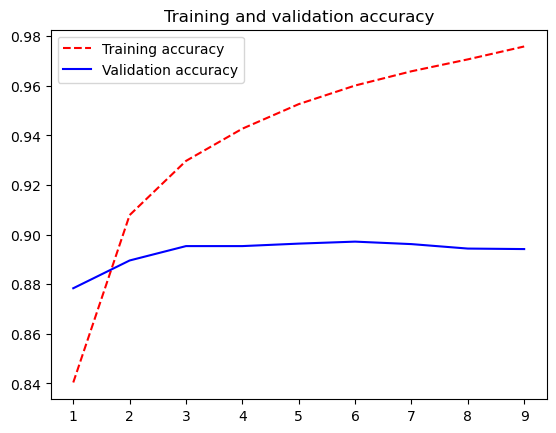

In [25]:
import matplotlib.pyplot as plt

accuracy = history.history["accuracy"]
val_accuracy = history.history["val_accuracy"]
epochs = range(1, len(accuracy) + 1)

plt.plot(epochs, accuracy, "r--", label="Training accuracy")
plt.plot(epochs, val_accuracy, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.show()

In [26]:
test_loss, test_acc = model.evaluate(bag_of_words_test_ds)
test_acc

782/782 [==============================] - 4s 5ms/step - loss: 0.2809 - accuracy: 0.8868


0.8867599964141846

### bigram model

In [27]:
max_tokens = 30_000
text_vectorization = layers.TextVectorization(
    max_tokens=max_tokens,
    # Learns a word-level vocabulary
    split="whitespace",
    output_mode="multi_hot",
    # Considers all unigrams and bigrams
    ngrams=2,
)
text_vectorization.adapt(train_ds_no_labels)

In [28]:
text_vectorization.get_vocabulary()

['[UNK]',
 'the',
 'and',
 'a',
 'of',
 'to',
 'is',
 'in',
 'it',
 'i',
 'this',
 'that',
 'br',
 'was',
 'as',
 'with',
 'for',
 'movie',
 'but',
 'of the',
 'film',
 'on',
 'not',
 'you',
 'his',
 'are',
 'have',
 'he',
 'be',
 'one',
 'in the',
 'its',
 'at',
 'all',
 'by',
 'an',
 'they',
 'from',
 'who',
 'so',
 'like',
 'her',
 'just',
 'or',
 'about',
 'has',
 'if',
 'out',
 'some',
 'what',
 'there',
 'this movie',
 'good',
 'when',
 'more',
 'very',
 'and the',
 'is a',
 'my',
 'she',
 'even',
 'no',
 'up',
 'the film',
 'would',
 'to the',
 'which',
 'time',
 'only',
 'to be',
 'really',
 'their',
 'story',
 'see',
 'had',
 'were',
 'the movie',
 'can',
 'me',
 'this film',
 'than',
 'it is',
 'we',
 'much',
 'well',
 'get',
 'this is',
 'been',
 'will',
 'into',
 'also',
 'on the',
 'people',
 'bad',
 'do',
 'other',
 'in a',
 'great',
 'how',
 'because',
 'first',
 'most',
 'him',
 'dont',
 'it was',
 'then',
 'one of',
 'for the',
 'made',
 'with the',
 'movies',
 'way',


In [29]:
bigram_train_ds = train_ds.map(lambda x, y: (text_vectorization(x), y))
bigram_val_ds = val_ds.map(lambda x, y: (text_vectorization(x), y))
bigram_test_ds = test_ds.map(lambda x, y: (text_vectorization(x), y))

In [30]:
x, y = next(bigram_train_ds.as_numpy_iterator())
x.shape

(32, 30000)

In [31]:
model = build_linear_classifier(max_tokens, "bigram_classifier")
model.fit(
    bigram_train_ds,
    validation_data=bigram_val_ds,
    epochs=10,
    callbacks=[early_stopping],
)

Epoch 1/10
625/625 [==============================] - 6s 10ms/step - loss: 0.3988 - accuracy: 0.8654 - val_loss: 0.3062 - val_accuracy: 0.8940
Epoch 2/10
625/625 [==============================] - 6s 9ms/step - loss: 0.2232 - accuracy: 0.9356 - val_loss: 0.2673 - val_accuracy: 0.9022
Epoch 3/10
625/625 [==============================] - 5s 9ms/step - loss: 0.1639 - accuracy: 0.9605 - val_loss: 0.2529 - val_accuracy: 0.9060
Epoch 4/10
625/625 [==============================] - 5s 9ms/step - loss: 0.1274 - accuracy: 0.9749 - val_loss: 0.2475 - val_accuracy: 0.9074
Epoch 5/10
625/625 [==============================] - 6s 9ms/step - loss: 0.1015 - accuracy: 0.9841 - val_loss: 0.2459 - val_accuracy: 0.9072
Epoch 6/10
625/625 [==============================] - 6s 9ms/step - loss: 0.0822 - accuracy: 0.9895 - val_loss: 0.2472 - val_accuracy: 0.9072
Epoch 7/10
625/625 [==============================] - 5s 9ms/step - loss: 0.0671 - accuracy: 0.9937 - val_loss: 0.2501 - val_accuracy: 0.9062


In [33]:
test_loss, test_acc = model.evaluate(bigram_test_ds)
test_acc

782/782 [==============================] - 5s 7ms/step - loss: 0.2506 - accuracy: 0.9010


0.9010000228881836

### 序列模型

In [ ]:
# "the quick brown fox jumped over the lazy dog"
#
# "the slow brown badger"
#
# ["the", "quick", "brown", "fox", "jumped", "over", "the", "lazy"]
# ["the", "slow", "brown", "badger", "[PAD]", "[PAD]", "[PAD]", "[PAD]"]

In [23]:
max_length = 600
max_tokens = 30_000
text_vectorization = layers.TextVectorization(
    max_tokens =max_tokens,
    split="whitespace",
    output_mode="int",

    # pads / truncates to 600 tokens
    output_sequence_length=max_length,
)

text_vectorization.adapt(train_ds_no_labels)

sequence_train_ds = train_ds.map(
    lambda x, y: (text_vectorization(x), y)
)
sequence_val_ds = val_ds.map(
    lambda x, y: (text_vectorization(x), y)
)
sequence_test_ds = test_ds.map(
    lambda x, y: (text_vectorization(x), y)
)

In [24]:
x, y = next(sequence_test_ds.as_numpy_iterator())
x.shape
x

(32, 600)

#### 训练循环网络

在每个时间步，常规循环层在生成输出之前只查看过去和现在的输入，这意味着无法看到未来。为了依据未来的输入去决定现在的编码，一种解决方案是在相同的输入上运行两个循环层（一个从左到右读取单词，另一个从右到左读取它们），然后在每个时间步组合它们的输出（直接连接起来，直接参与该时间步的预测）

![双向RNN](./images/RNN/p8.png)

In [48]:
from keras import backend as K
from keras.layers import Layer

class OneHotEncoding(Layer):
    def __init__(self, depth, **kwargs):
        super().__init__(**kwargs)
        self.depth = depth

    def call(self, inputs):
       return K.one_hot(K.cast(inputs, "int32"), self.depth)

one_hot_encoding = OneHotEncoding(max_tokens)

In [49]:
x, y = next(sequence_train_ds.as_numpy_iterator())
one_hot_encoding(x).shape

TensorShape([32, 600, 30000])

In [50]:
hidden_dim = 64
inputs = keras.Input(shape=(max_length,), dtype="int32")
x= one_hot_encoding(inputs)
x = layers.Bidirectional(layers.LSTM(hidden_dim))(x)
x = layers.Dropout(0.5)(x)

outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs, outputs, name="lstm_with_one_hot")
model.compile(
    optimizer="adam",
    loss="binary_crossentropy",
    metrics=["accuracy"],
)

In [51]:
model.summary()

Model: "lstm_with_one_hot"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 600)]             0         
                                                                 
 one_hot_encoding_3 (OneHot  (None, 600, 30000)        0         
 Encoding)                                                       
                                                                 
 bidirectional (Bidirection  (None, 128)               15393280  
 al)                                                             
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_2 (Dense)             (None, 1)                 129       
                                                                 
Total params: 15393409 (58.72 MB)
Trainable param

In [ ]:
# WARNING: 训练时间非常长
model.fit(
    sequence_train_ds,
    validation_data=sequence_val_ds,
    epochs=10,
    callbacks=[early_stopping],
)

Epoch 1/10
169/625 [=======>......................] - ETA: 2:40:05 - loss: 0.6832 - accuracy: 0.5636

In [ ]:
test_loss, test_acc = model.evaluate(sequence_test_ds)
test_acc

It’s common to see word embeddings that are 256-dimensional, 512-dimensional, or 1,024-dimensional when dealing with very large vocabularies. On the other hand, one-hot encoding words generally leads to vectors that are 30,000-dimensional in the case of our current vocabulary. So word embeddings pack more information into far fewer dimensions.

![token到embedding](./images/RNN/p9.png)

The Embedding layer takes as input a rank-2 tensor with shape (batch_size, sequence_length), where each entry is a sequence of integers. The layer returns a floating-point tensor of shape (batch_size, sequence_length, embedding_size).

In [25]:
hidden_dim = 64

inputs = keras.Input(shape=(max_length,), dtype="int32")

x = keras.layers.Embedding(
    input_dim=max_tokens,
    output_dim=hidden_dim,
    mask_zero=True, # mask all elements that initially conatained a zero
)(inputs)
x = keras.layers.Bidirectional(keras.layers.LSTM(hidden_dim))(x)
x = keras.layers.Dropout(0.5)(x)
outputs = keras.layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs, outputs, name="lstm_with_embedding")
model.compile(
    optimizer="adam",
    loss="binary_crossentropy",
    metrics=["accuracy"],
)

In [26]:
model.fit(
    sequence_train_ds,
    validation_data=sequence_val_ds,
    epochs=10,
    callbacks=[early_stopping],
)

Epoch 1/10
625/625 [==============================] - 121s 188ms/step - loss: 0.4470 - accuracy: 0.7876 - val_loss: 0.3513 - val_accuracy: 0.8472
Epoch 2/10
625/625 [==============================] - 116s 186ms/step - loss: 0.2420 - accuracy: 0.9062 - val_loss: 0.3396 - val_accuracy: 0.8718
Epoch 3/10
625/625 [==============================] - 118s 188ms/step - loss: 0.1161 - accuracy: 0.9586 - val_loss: 0.3314 - val_accuracy: 0.8704
Epoch 4/10
625/625 [==============================] - 119s 190ms/step - loss: 0.0626 - accuracy: 0.9801 - val_loss: 0.4099 - val_accuracy: 0.8620
Epoch 5/10
625/625 [==============================] - 118s 189ms/step - loss: 0.0404 - accuracy: 0.9872 - val_loss: 0.4685 - val_accuracy: 0.8658


In [ ]:
test_loss, test_acc = model.evaluate(sequence_test_ds)
test_acc

#### 预训练词嵌入

In [27]:
imdb_vocabulary = text_vectorization.get_vocabulary()
tokenize_no_padding = keras.layers.TextVectorization(
    vocabulary=imdb_vocabulary,
    split="whitespace",
    output_mode="int"
)

In [28]:
import tensorflow as tf

# Words to the left or right of label
context_size = 4
# Total window size
window_size = 9

def window_data(token_ids):
    num_windows = tf.maximum(tf.size(token_ids) - context_size * 2, 0)
    windows = tf.range(window_size)[None, :]
    windows = windows + tf.range(num_windows)[:, None]
    windowed_tokens = tf.gather(token_ids, windows)
    return tf.data.Dataset.from_tensor_slices(windowed_tokens)

def split_label(window):
    left = window[:context_size]
    right = window[context_size + 1 :]
    bag = tf.concat((left, right), axis=0)
    label = window[context_size]
    return bag, label

# Uses all training data, including the unsup/ directory
dataset = keras.utils.text_dataset_from_directory(
    imdb_extract_dir / "train", batch_size=None
)
# Drops label
dataset = dataset.map(lambda x, y: x, num_parallel_calls=8)
# Tokenizes
dataset = dataset.map(tokenize_no_padding, num_parallel_calls=8)
# Creates context windows
dataset = dataset.interleave(window_data, cycle_length=8, num_parallel_calls=8)
# Splits middle wonder into a label
dataset = dataset.map(split_label, num_parallel_calls=8)

Found 75000 files belonging to 3 classes.


In [30]:
hidden_dim = 64
inputs = keras.Input(shape=(2 * context_size,))
cbow_embedding = layers.Embedding(
    max_tokens,
    hidden_dim,
)
x = cbow_embedding(inputs)
x = layers.GlobalAveragePooling1D()(x)
outputs = layers.Dense(max_tokens, activation="sigmoid")(x)
cbow_model = keras.Model(inputs, outputs)
cbow_model.compile(
    optimizer="adam",
    loss="sparse_categorical_crossentropy",
    metrics=["sparse_categorical_accuracy"],
)

In [31]:
cbow_model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 8)]               0         
                                                                 
 embedding_3 (Embedding)     (None, 8, 64)             1920000   
                                                                 
 global_average_pooling1d_1  (None, 64)                0         
  (GlobalAveragePooling1D)                                       
                                                                 
 dense_3 (Dense)             (None, 30000)             1950000   
                                                                 
Total params: 3870000 (14.76 MB)
Trainable params: 3870000 (14.76 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
dataset = dataset.batch(1024).cache()
cbow_model.fit(dataset, epochs=4)

Epoch 1/4
   3087/Unknown - 695s 225ms/step - loss: 6.9662 - sparse_categorical_accuracy: 0.0613

In [ ]:
inputs = keras.Input(shape=(max_length,))
lstm_embedding = layers.Embedding(
    input_dim=max_tokens,
    output_dim=hidden_dim,
    mask_zero=True,
)
x = lstm_embedding(inputs)
x = layers.Bidirectional(layers.LSTM(hidden_dim))(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs, outputs, name="lstm_with_cbow")

lstm_embedding.embeddings.assign(cbow_embedding.embeddings)

model.compile(
    optimizer="adam",
    loss="binary_crossentropy",
    metrics=["accuracy"],
)
model.fit(
    sequence_train_ds,
    validation_data=sequence_val_ds,
    epochs=10,
    callbacks=[early_stopping],
)